# nuScenes devkit tutorial

Welcome to the nuScenes tutorial. This demo assumes the database itself is available at `/data/sets/nuscenes`, and loads a mini version of the full dataset.

## A Gentle Introduction to nuScenes

In this part of the tutorial, let us go through a top-down introduction of our database. Our dataset comprises of elemental building blocks that are the following:

1. `log` - Log information from which the data was extracted.
2. `scene` - 20 second snippet of a car's journey.
3. `sample` - An annotated snapshot of a scene at a particular timestamp.
4. `sample_data` - Data collected from a particular sensor.
5. `ego_pose` - Ego vehicle poses at a particular timestamp.
6. `sensor` - A specific sensor type.
7. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
8. `instance` - Enumeration of all object instance we observed.
9. `category` - Taxonomy of object categories (e.g. vehicle, human).
10. `attribute` - Property of an instance that can change while the category remains the same.
11. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.
12. `sample_annotation` - An annotated instance of an object within our interest.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

The database schema is visualized below. For more information see the [nuScenes schema](https://github.com/nutonomy/nuscenes-devkit/blob/master/docs/schema_nuscenes.md) page.
![](https://www.nuscenes.org/public/images/nuscenes-schema.svg)

## Google Colab (optional)

<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuscenes_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left">
</a>
<br>

If you are running this notebook in Google Colab, you can uncomment the cell below and run it; everything will be set up nicely for you. Otherwise, manually set up everything.

In [1]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2025-02-01 11:20:06--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.224.14.15, 13.224.14.105, 13.224.14.23, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.224.14.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G  85.3MB/s    in 46s     

2025-02-01 11:20:52 (85.7 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [2]:
!ls -lh /data/sets/nuscenes

total 16K
drwxr-xr-x  2 1035 1035 4.0K Mar 22  2019 maps
drwxrwxr-x 14 1035 1035 4.0K Mar 17  2019 samples
drwxrwxr-x 14 1035 1035 4.0K Mar 17  2019 sweeps
drwxr-xr-x  2 1035 1035 4.0K Mar 22  2019 v1.0-mini


## Initialization

In [3]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.768 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## A look at the dataset

### 1. `scene`

nuScenes is a large scale database that features annotated samples across ***1000 scenes*** of approximately 20 seconds each. Let's take a look at the scenes that we have in the loaded database.

In [4]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

Let's look at a scene metadata

In [5]:
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

### 2. `sample`

In scenes, we annotate our data every half a second (2 Hz).

We define `sample` as an ***annotated keyframe of a scene at a given timestamp***. A keyframe is a frame where the time-stamps of data from all the sensors should be very close to the time-stamp of the sample it points to.

Now, let us look at the first annotated sample in this scene.

In [7]:
first_sample_token = my_scene['first_sample_token']

# The rendering command below is commented out because it tends to crash in notebooks
# nusc.render_sample(first_sample_token)

Let's examine its metadata

In [8]:
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

A useful method is  `list_sample()` which lists all related `sample_data` keyframes and `sample_annotation` associated with a `sample` which we will discuss in detail in the subsequent parts.

In [9]:
nusc.list_sample(my_sample['token'])

Sample: ca9a282c9e77460f8360f564131a8af5

sample_data_token: 37091c75b9704e0daa829ba56dfa0906, mod: radar, channel: RADAR_FRONT
sample_data_token: 11946c1461d14016a322916157da3c7d, mod: radar, channel: RADAR_FRONT_LEFT
sample_data_token: 491209956ee3435a9ec173dad3aaf58b, mod: radar, channel: RADAR_FRONT_RIGHT
sample_data_token: 312aa38d0e3e4f01b3124c523e6f9776, mod: radar, channel: RADAR_BACK_LEFT
sample_data_token: 07b30d5eb6104e79be58eadf94382bc1, mod: radar, channel: RADAR_BACK_RIGHT
sample_data_token: 9d9bf11fb0e144c8b446d54a8a00184f, mod: lidar, channel: LIDAR_TOP
sample_data_token: e3d495d4ac534d54b321f50006683844, mod: camera, channel: CAM_FRONT
sample_data_token: aac7867ebf4f446395d29fbd60b63b3b, mod: camera, channel: CAM_FRONT_RIGHT
sample_data_token: 79dbb4460a6b40f49f9c150cb118247e, mod: camera, channel: CAM_BACK_RIGHT
sample_data_token: 03bea5763f0f4722933508d5999c5fd8, mod: camera, channel: CAM_BACK
sample_data_token: 43893a033f9c46d4a51b5e08a67a1eb7, mod: camera, channel:

### 3. `sample_data`

The nuScenes dataset contains data that is collected from a full sensor suite. Hence, for each snapshot of a scene, we provide references to a family of data that is collected from these sensors.

We provide a `data` key to access these:

In [10]:
my_sample['data']

{'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
 'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
 'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
 'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
 'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
 'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
 'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
 'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
 'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
 'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
 'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
 'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'}

Notice that the keys are referring to the different sensors that form our sensor suite. Let's take a look at the metadata of a `sample_data` taken from `CAM_FRONT`.

In [11]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data

{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

We can also render the `sample_data` at a particular sensor.

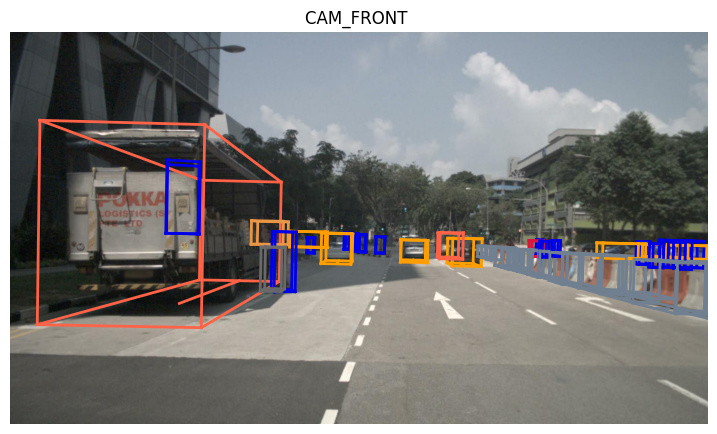

In [12]:
nusc.render_sample_data(cam_front_data['token'])

### 4. `sample_annotation`

`sample_annotation` refers to any ***bounding box defining the position of an object seen in a sample***. All location data is given with respect to the global coordinate system. Let's examine an example from our `sample` above.

In [13]:
my_annotation_token = my_sample['anns'][18]
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata

{'token': '83d881a6b3d94ef3a3bc3b585cc514f8',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': 'e91afa15647c4c4994f19aeb302c7179',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [409.989, 1164.099, 1.623],
 'size': [2.877, 10.201, 3.595],
 'rotation': [-0.5828819500503033, 0.0, 0.0, 0.812556848660791],
 'prev': '',
 'next': 'f3721bdfd7ee4fd2a4f94874286df471',
 'num_lidar_pts': 495,
 'num_radar_pts': 13,
 'category_name': 'vehicle.truck'}

We can also render an annotation to have a closer look.

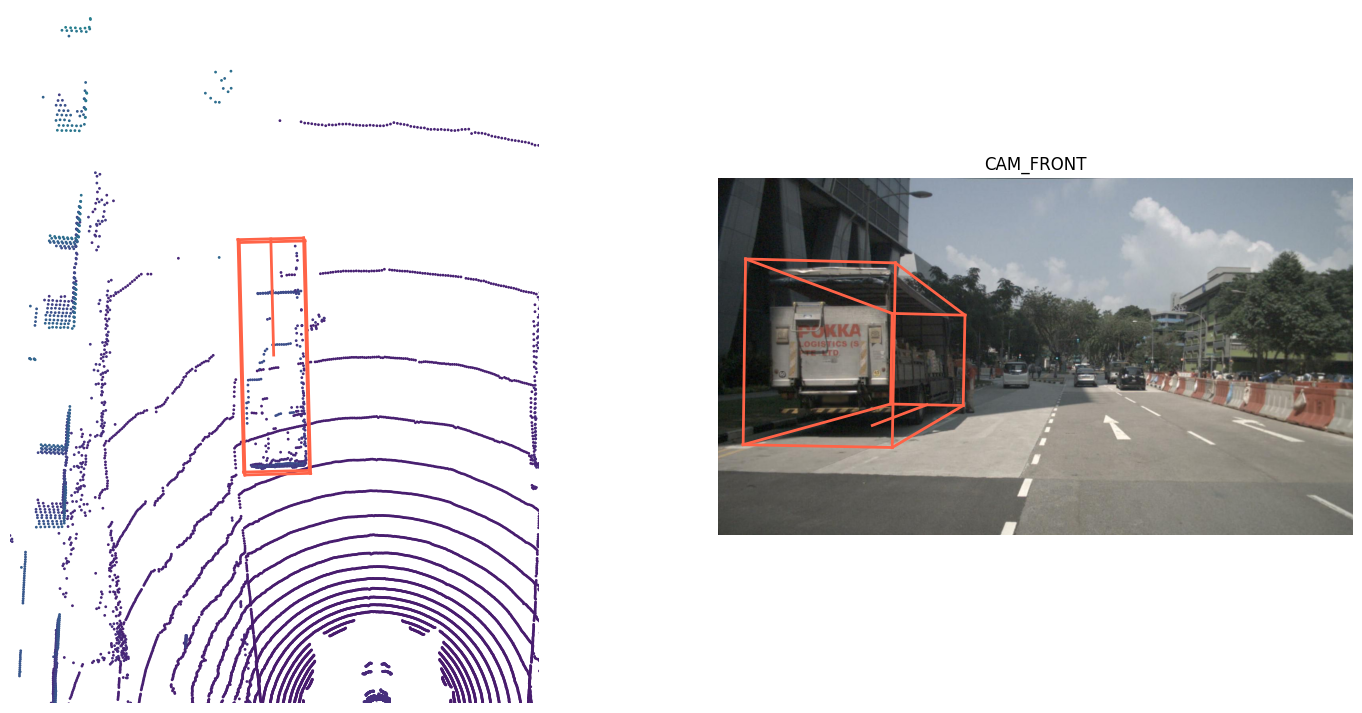

In [14]:
nusc.render_annotation(my_annotation_token)

### 5. `instance`

Object instance are instances that need to be detected or tracked by an AV (e.g a particular vehicle, pedestrian). Let us examine an instance metadata

In [15]:
my_instance = nusc.instance[599]
my_instance

{'token': '9cba9cd8af85487fb010652c90d845b5',
 'category_token': 'fedb11688db84088883945752e480c2c',
 'nbr_annotations': 16,
 'first_annotation_token': '77afa772cb4a4e5c8a5a53f2019bdba0',
 'last_annotation_token': '6fed6d902e5e487abb7444f62e1a2341'}

We generally track an instance across different frames in a particular scene. However, we do not track them across different scenes. In this example, we have 16 annotated samples for this instance across a particular scene.

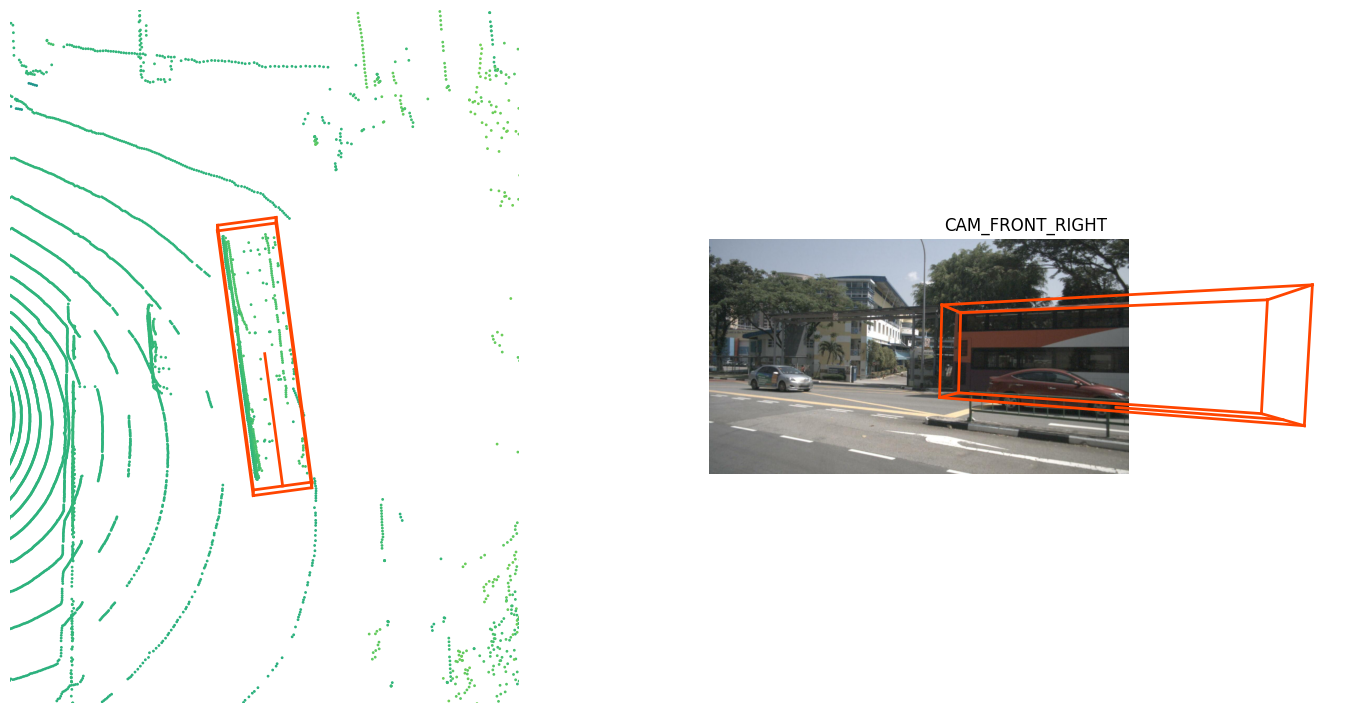

In [16]:
instance_token = my_instance['token']
nusc.render_instance(instance_token)

An instance record takes note of its first and last annotation token. Let's render them

First annotated sample of this instance:


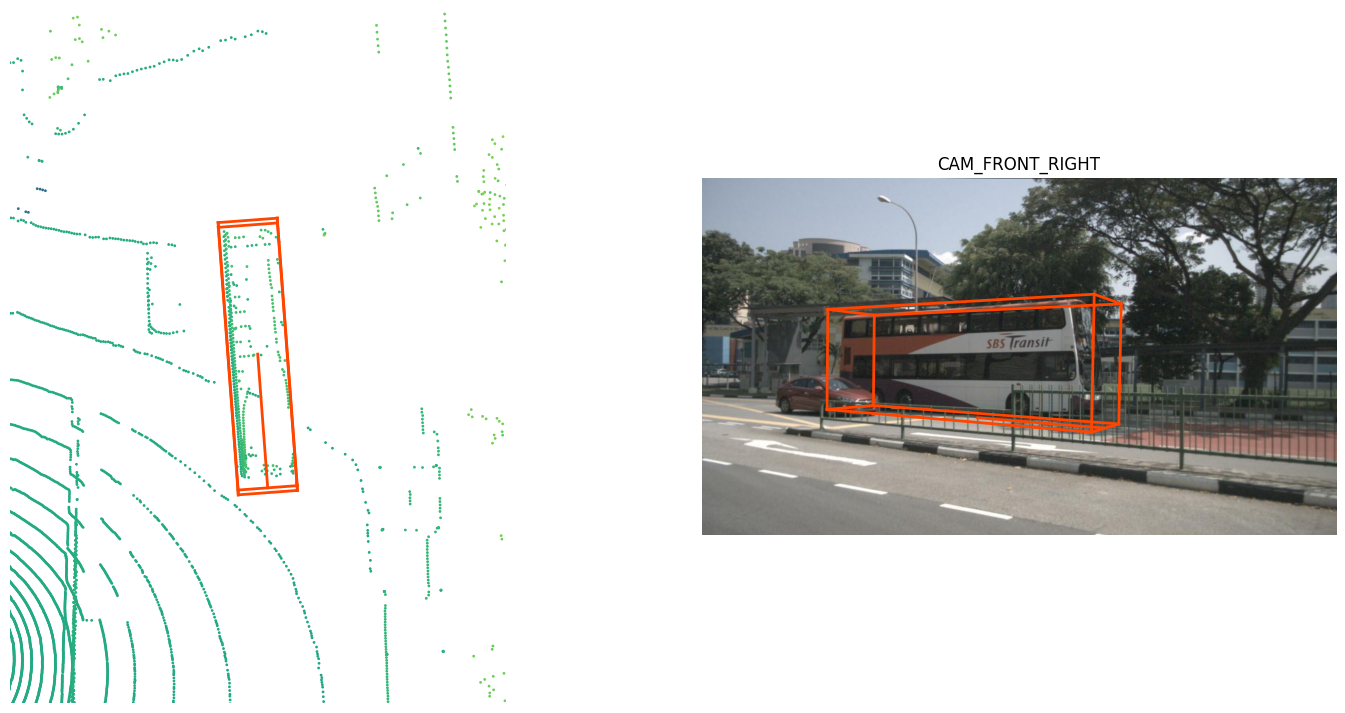

In [19]:
print("First annotated sample of this instance:")
nusc.render_annotation(my_instance['first_annotation_token'])

Last annotated sample of this instance


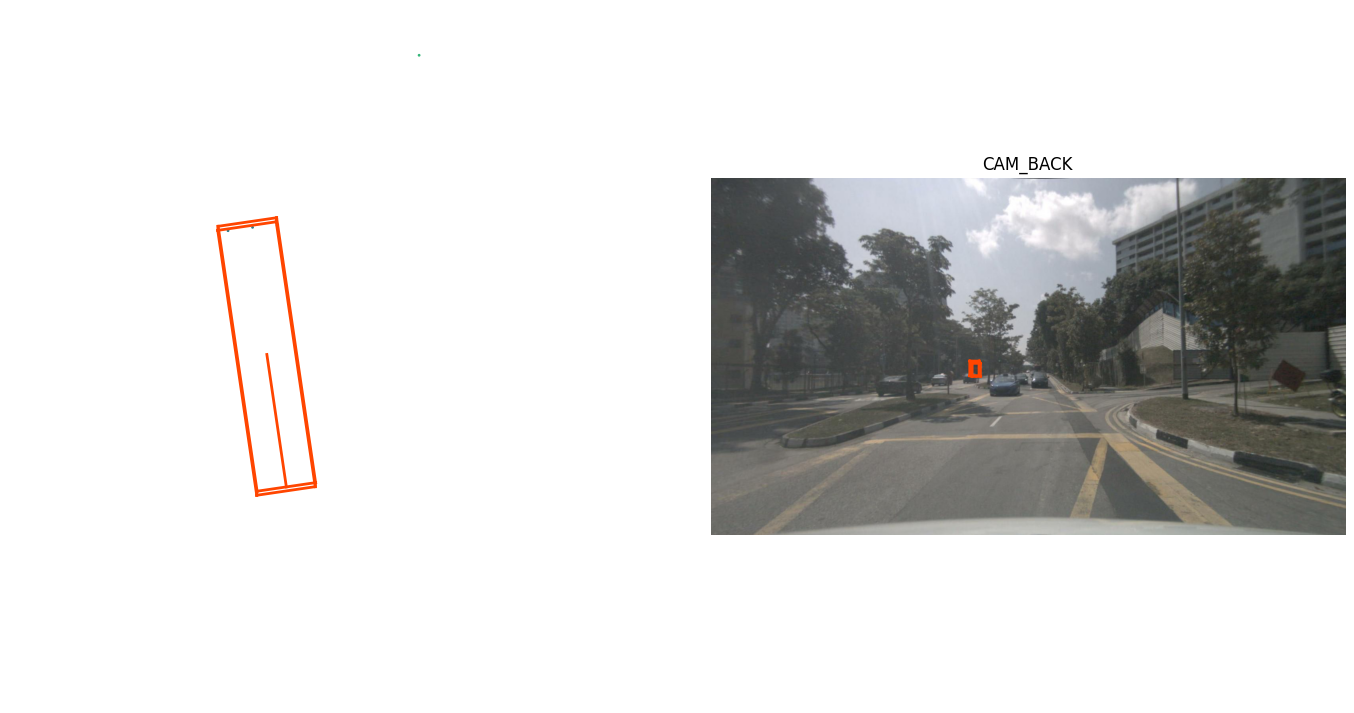

In [18]:
print("Last annotated sample of this instance")
nusc.render_annotation(my_instance['last_annotation_token'])

### 6. `category`

A `category` is the object assignment of an annotation.  Let's look at the category table we have in our database. The table contains the taxonomy of different object categories and also list the subcategories (delineated by a period).

In [20]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

A category record contains the name and the description of that particular category.

In [21]:
nusc.category[9]

{'token': 'dfd26f200ade4d24b540184e16050022',
 'name': 'vehicle.motorcycle',
 'description': 'Gasoline or electric powered 2-wheeled vehicle designed to move rapidly (at the speed of standard cars) on the road surface. This category includes all motorcycles, vespas and scooters.'}

Refer to `instructions_nuscenes.md` for the definitions of the different categories.

### 7. `attribute`

An `attribute` is a property of an instance that may change throughout different parts of a scene while the category remains the same. Here we list the provided attributes and the number of annotations associated with a particular attribute.

In [22]:
nusc.list_attributes()

cycle.with_rider: 305
cycle.without_rider: 434
pedestrian.moving: 3875
pedestrian.sitting_lying_down: 111
pedestrian.standing: 1029
vehicle.moving: 2715
vehicle.parked: 4674
vehicle.stopped: 1545


Let's take a look at an example how an attribute may change over one scene

In [23]:
my_instance = nusc.instance[27]
first_token = my_instance['first_annotation_token']
last_token = my_instance['last_annotation_token']
nbr_samples = my_instance['nbr_annotations']
current_token = first_token

i = 0
found_change = False
while current_token != last_token:
    current_ann = nusc.get('sample_annotation', current_token)
    current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']

    if i == 0:
        pass
    elif current_attr != last_attr:
        print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attr, current_attr, i, nbr_samples))
        found_change = True

    next_token = current_ann['next']
    current_token = next_token
    last_attr = current_attr
    i += 1

Changed from `pedestrian.moving` to `pedestrian.standing` at timestamp 21 out of 39 annotated timestamps


### 8. `visibility`

`visibility` is defined as the fraction of pixels of a particular annotation that are visible over the 6 camera feeds, grouped into 4 bins.

In [24]:
nusc.visibility

[{'description': 'visibility of whole object is between 0 and 40%',
  'token': '1',
  'level': 'v0-40'},
 {'description': 'visibility of whole object is between 40 and 60%',
  'token': '2',
  'level': 'v40-60'},
 {'description': 'visibility of whole object is between 60 and 80%',
  'token': '3',
  'level': 'v60-80'},
 {'description': 'visibility of whole object is between 80 and 100%',
  'token': '4',
  'level': 'v80-100'}]

Let's look at an example `sample_annotation` with 80-100% visibility

Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}


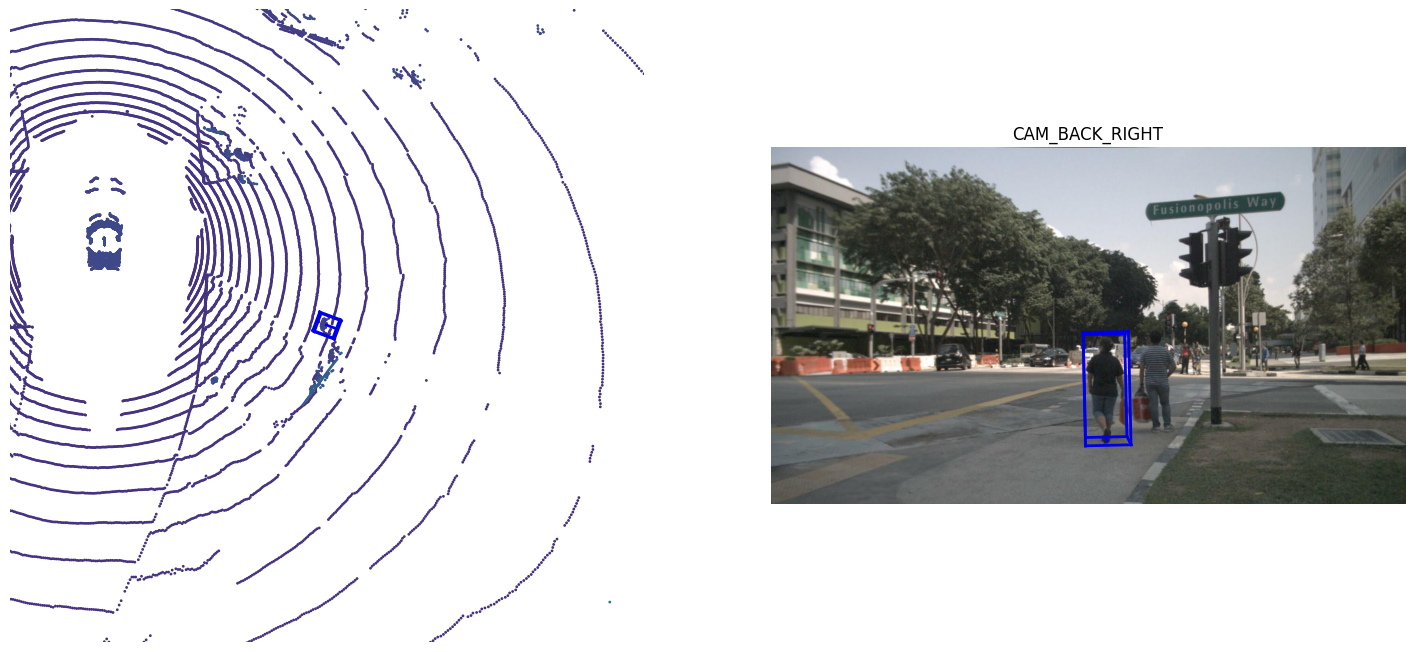

In [25]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Let's look at an example `sample_annotation` with 0-40% visibility

Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}


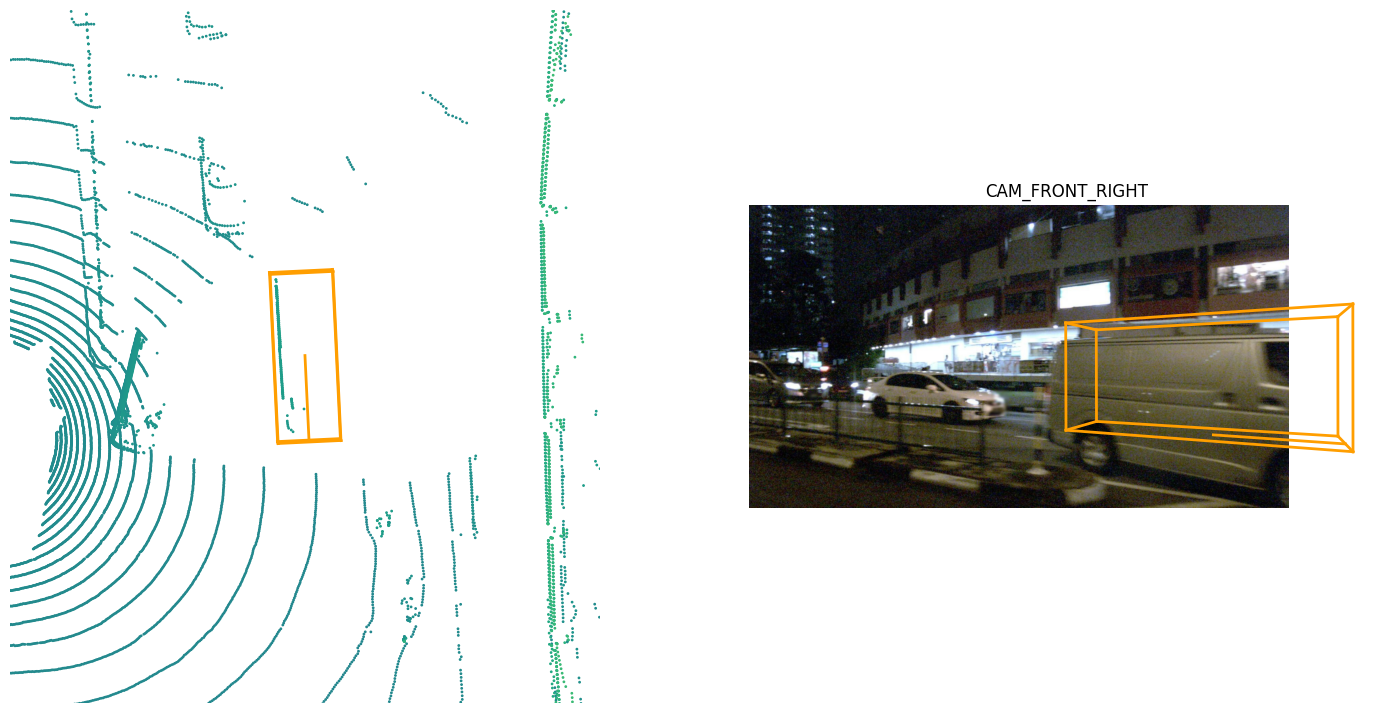

In [26]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

### 9. `sensor`

The nuScenes dataset consists of data collected from our full sensor suite which consists of:
- 1 x LIDAR,
- 5 x RADAR,
- 6 x cameras,

In [27]:
nusc.sensor

[{'token': '725903f5b62f56118f4094b46a4470d8',
  'channel': 'CAM_FRONT',
  'modality': 'camera'},
 {'token': 'ce89d4f3050b5892b33b3d328c5e82a3',
  'channel': 'CAM_BACK',
  'modality': 'camera'},
 {'token': 'a89643a5de885c6486df2232dc954da2',
  'channel': 'CAM_BACK_LEFT',
  'modality': 'camera'},
 {'token': 'ec4b5d41840a509984f7ec36419d4c09',
  'channel': 'CAM_FRONT_LEFT',
  'modality': 'camera'},
 {'token': '2f7ad058f1ac5557bf321c7543758f43',
  'channel': 'CAM_FRONT_RIGHT',
  'modality': 'camera'},
 {'token': 'ca7dba2ec9f95951bbe67246f7f2c3f7',
  'channel': 'CAM_BACK_RIGHT',
  'modality': 'camera'},
 {'token': 'dc8b396651c05aedbb9cdaae573bb567',
  'channel': 'LIDAR_TOP',
  'modality': 'lidar'},
 {'token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'channel': 'RADAR_FRONT',
  'modality': 'radar'},
 {'token': '232a6c4dc628532e81de1c57120876e9',
  'channel': 'RADAR_FRONT_RIGHT',
  'modality': 'radar'},
 {'token': '1f69f87a4e175e5ba1d03e2e6d9bcd27',
  'channel': 'RADAR_FRONT_LEFT',
  'modality'

Every `sample_data` has a record on which `sensor` the data is collected from (note the "channel" key)

In [28]:
nusc.sample_data[10]

{'token': '2ecfec536d984fb491098c9db1404117',
 'sample_token': '356d81f38dd9473ba590f39e266f54e5',
 'ego_pose_token': '2ecfec536d984fb491098c9db1404117',
 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'timestamp': 1532402928269133,
 'fileformat': 'pcd',
 'is_key_frame': False,
 'height': 0,
 'width': 0,
 'filename': 'sweeps/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928269133.pcd',
 'prev': 'b933bbcb4ee84a7eae16e567301e1df2',
 'next': '79ef24d1eba84f5abaeaf76655ef1036',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

### 10. `calibrated_sensor`

`calibrated_sensor` consists of the definition of a particular sensor (lidar/radar/camera) as calibrated on a particular vehicle. Let us look at an example.

In [29]:
nusc.calibrated_sensor[0]

{'token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
 'translation': [3.412, 0.0, 0.5],
 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088],
 'camera_intrinsic': []}

Note that the `translation` and the `rotation` parameters are given with respect to the ego vehicle body frame.

### 11. `ego_pose`

`ego_pose` contains information about the location (encoded in `translation`) and the orientation (encoded in `rotation`) of the ego vehicle, with respect to the global coordinate system.

In [30]:
nusc.ego_pose[0]

{'token': '5ace90b379af485b9dcb1584b01e7212',
 'timestamp': 1532402927814384,
 'rotation': [0.5731787718287827,
  -0.0015811634307974854,
  0.013859363182046986,
  -0.8193116095230444],
 'translation': [410.77878632230204, 1179.4673290964536, 0.0]}

Note that the number of `ego_pose` records in our loaded database is the same as the number of `sample_data` records. These two records exhibit a one-to-one correspondence.

### 12. `log`

The `log` table contains log information from which the data was extracted. A `log` record corresponds to one journey of our ego vehicle along a predefined route. Let's check the number of logs and the metadata of a log.

In [31]:
print("Number of `logs` in our loaded database: {}".format(len(nusc.log)))

Number of `logs` in our loaded database: 8


In [32]:
nusc.log[0]

{'token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'logfile': 'n015-2018-07-24-11-22-45+0800',
 'vehicle': 'n015',
 'date_captured': '2018-07-24',
 'location': 'singapore-onenorth',
 'map_token': '53992ee3023e5494b90c316c183be829'}

Notice that it contains a variety of information such as the date and location of the log collected. It also gives out information about the map from where the data was collected. Note that one log can contain multiple non-overlapping scenes.

### 13. `map`

Map information is stored as binary semantic masks from a top-down view. Let's check the number of maps and metadata of a map.

In [33]:
print("There are {} maps masks in the loaded dataset".format(len(nusc.map)))

There are 4 maps masks in the loaded dataset


In [34]:
nusc.map[0]

{'category': 'semantic_prior',
 'token': '53992ee3023e5494b90c316c183be829',
 'filename': 'maps/53992ee3023e5494b90c316c183be829.png',
 'log_tokens': ['0986cb758b1d43fdaa051ab23d45582b',
  '1c9b302455ff44a9a290c372b31aa3ce',
  'e60234ec7c324789ac7c8441a5e49731',
  '46123a03f41e4657adc82ed9ddbe0ba2',
  'a5bb7f9dd1884f1ea0de299caefe7ef4',
  'bc41a49366734ebf978d6a71981537dc',
  'f8699afb7a2247e38549e4d250b4581b',
  'd0450edaed4a46f898403f45fa9e5f0d',
  'f38ef5a1e9c941aabb2155768670b92a',
  '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
  'ddc03471df3e4c9bb9663629a4097743',
  '31e9939f05c1485b88a8f68ad2cf9fa4',
  '783683d957054175bda1b326453a13f4',
  '343d984344e440c7952d1e403b572b2a',
  '92af2609d31445e5a71b2d895376fed6',
  '47620afea3c443f6a761e885273cb531',
  'd31dc715d1c34b99bd5afb0e3aea26ed',
  '34d0574ea8f340179c82162c6ac069bc',
  'd7fd2bb9696d43af901326664e42340b',
  'b5622d4dcb0d4549b813b3ffb96fbdc9',
  'da04ae0b72024818a6219d8dd138ea4b',
  '6b6513e6c8384cec88775cae30b78c0e',
  'eda311bda86f

## nuScenes Basics

Let's get a bit technical.

The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [35]:
nusc.category[0]

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.'}

The category table is simple: it holds the fields `name` and `description`. It also has a `token` field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:

In [36]:
cat_token = nusc.category[0]['token']
cat_token

'1fa93b757fc74fb197cdd60001ad8abf'

If you know the `token` for any record in the DB you can retrieve the record by doing

In [37]:
nusc.get('category', cat_token)

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.'}

_As you can notice, we have recovered the same record!_

OK, that was easy. Let's try something harder. Let's look at the `sample_annotation` table.

In [38]:
nusc.sample_annotation[0]

{'token': '70aecbe9b64f4722ab3c230391a3beb8',
 'sample_token': 'cd21dbfc3bd749c7b10a5c42562e0c42',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '4',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.214, 1130.48, 1.25],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': 'a1721876c0944cdd92ebc3c75d55d693',
 'next': '1e8e35d365a441a18dd5503a0ee1c208',
 'num_lidar_pts': 5,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

This also has a `token` field (they all do). In addition, it has several fields of the format [a-z]*\_token, _e.g._ instance_token. These are foreign keys in database terminology, meaning they point to another table.
Using `nusc.get()` we can grab any of these in constant time. For example, let's look at the visibility record.

In [40]:
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

{'description': 'visibility of whole object is between 80 and 100%',
 'token': '4',
 'level': 'v80-100'}

The visibility records indicate how much of an object was visible when it was annotated.

Let's also grab the `instance_token`

In [39]:
one_instance = nusc.get('instance', nusc.sample_annotation[0]['instance_token'])
one_instance

{'token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'category_token': '1fa93b757fc74fb197cdd60001ad8abf',
 'nbr_annotations': 39,
 'first_annotation_token': 'ef63a697930c4b20a6b9791f423351da',
 'last_annotation_token': '8bb63134d48840aaa2993f490855ff0d'}

This points to the `instance` table. This table enumerate the object _instances_ we have encountered in each
scene. This way we can connect all annotations of a particular object.

If you look carefully at the README tables, you will see that the sample_annotation table points to the instance table,
but the instance table doesn't list all annotations that point to it.

So how can we recover all sample_annotations for a particular object instance? There are two ways:

1. `Use nusc.field2token()`. Let's try it:

In [47]:
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])

This returns a list of all sample_annotation records with the `'instance_token'` == `one_instance['token']`. Let's store these in a set for now

In [48]:
ann_tokens_field2token = set(ann_tokens)

ann_tokens_field2token

{'05e0ad1194804f548be544f2267c7e74',
 '060be69422ee4b2a8b239b463b995e92',
 '146b2111cc0c401ca09d96777758d81e',
 '163d85048698495dbf55a35f613c5fb9',
 '17a6843fefcd4b2b811eddbb1ccd708d',
 '1de9ad564050444486eb587360cf135f',
 '1e8e35d365a441a18dd5503a0ee1c208',
 '23f10d5f0d254068941be8797493c7eb',
 '2b5948828cdb49e3be6be1320381bbbf',
 '3a930d1793434d9a8a87d6eba28ff70e',
 '3b24f083c0bf42d695a1040efdab7ffe',
 '4e41d9560dbf46cab1568b8ef6a282f3',
 '6f371d3f0d7d494eaa6f81daa3df58c0',
 '70aecbe9b64f4722ab3c230391a3beb8',
 '74f550e3257c4f52af1102c0d49d37b8',
 '7670ac8bc5044d5a9e11e205c839385d',
 '794fcc425f074a1392206ed925fdbbd8',
 '7987617983634b119e383d8a29607fd7',
 '7fa3a688931b4500b7ce29d187d3b975',
 '807b3e029a6b4e428f6cc82fc26a35a7',
 '8bb63134d48840aaa2993f490855ff0d',
 '90d94112b9ea4fb691e988b40af5b161',
 '913072e56d6c4025b9b47ba085dd6d7c',
 '93d5b79041c64693a5b32f1103a39a06',
 '9acb7dfed3454f72b2874dda3bdacc48',
 'a1721876c0944cdd92ebc3c75d55d693',
 'a2b20cdbf1ed4018ac795b8845d5deaa',
 

The `nusc.field2token()` method is generic and can be used in any similar situation.

2. For certain situation, we provide some reverse indices in the tables themselves. This is one such example.

The instance record has a field `first_annotation_token` which points to the first annotation in time of this instance.
Recovering this record is easy.

In [49]:
ann_record = nusc.get('sample_annotation', one_instance['first_annotation_token'])
ann_record

{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

Now we can traverse all annotations of this instance using the "next" field. Let's try it.

In [55]:
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

Finally, let's assert that we recovered the same ann_records as we did using nusc.field2token:

In [56]:
print(ann_tokens_traverse == ann_tokens_field2token)

False


## Reverse indexing and short-cuts

The nuScenes tables are normalized, meaning that each piece of information is only given once.
For example, there is one `map` record for each `log` record. Looking at the schema you will notice that the `map` table has a `log_token` field, but that the `log` table does not have a corresponding `map_token` field. But there are plenty of situations where you have a `log`, and want to find the corresponding `map`! So what to do? You can always use the `nusc.field2token()` method, but that is slow and inconvenient. We therefore add reverse mappings for some common situations including this one.

Further, there are situations where one needs to go through several tables to get a certain piece of information.
Consider, for example, the category name (e.g. `human.pedestrian`) of a `sample_annotation`. The `sample_annotation` table doesn't hold this information since the category is an instance level constant. Instead the `sample_annotation` table points to a record in the `instance` table. This, in turn, points to a record in the `category` table, where finally the `name` fields stores the required information.

Since it is quite common to want to know the category name of an annotation, we add a `category_name` field to the `sample_annotation` table during initialization of the NuScenes class.

In this section, we list the short-cuts and reverse indices that are added to the `NuScenes` class during initialization. These are all created in the `NuScenes.__make_reverse_index__()` method.

### Reverse indices
We add two reverse indices by default.
* A `map_token` field is added to the `log` records.
* The `sample` records have shortcuts to all `sample_annotations` for that record as well as `sample_data` key-frames. Confer `nusc.list_sample()` method in the previous section for more details on this.

### Shortcuts

The sample_annotation table has a "category_name" shortcut.

_Using shortcut:_

In [57]:
catname = nusc.sample_annotation[0]['category_name']

_Not using shortcut:_

In [58]:
ann_rec = nusc.sample_annotation[0]
inst_rec = nusc.get('instance', ann_rec['instance_token'])
cat_rec = nusc.get('category', inst_rec['category_token'])

print(catname == cat_rec['name'])

True


The sample_data table has "channel" and "sensor_modality" shortcuts:

In [59]:
# Shortcut
channel = nusc.sample_data[0]['channel']

# No shortcut
sd_rec = nusc.sample_data[0]
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
sensor_record = nusc.get('sensor', cs_record['sensor_token'])

print(channel == sensor_record['channel'])

True


## Data Visualizations

We provide list and rendering methods. These are meant both as convenience methods during development, and as tutorials for building your own visualization methods. They are implemented in the NuScenesExplorer class, with shortcuts through the NuScenes class itself.

### List methods
There are three list methods available.

1. `list_categories()` lists all categories, counts and statistics of width/length/height in meters and aspect ratio.

In [60]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

2. `list_attributes()` lists all attributes and counts.

In [61]:
nusc.list_attributes()

cycle.with_rider: 305
cycle.without_rider: 434
pedestrian.moving: 3875
pedestrian.sitting_lying_down: 111
pedestrian.standing: 1029
vehicle.moving: 2715
vehicle.parked: 4674
vehicle.stopped: 1545


3. `list_scenes()` lists all scenes in the loaded DB.

In [62]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

### Render

First, let's plot a lidar point cloud in an image. Lidar allows us to accurately map the surroundings in 3D.

In [65]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

AssertionError: Unsupported filetype /data/sets/nuscenes/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402932612460.jpg

In the previous image the colors indicate the distance from the ego vehicle to each lidar point. We can also render the lidar intensity. In the following image the traffic sign ahead of us is highly reflective (yellow) and the dark vehicle on the right has low reflectivity (purple).

In [66]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP', render_intensity=True)

AssertionError: Unsupported filetype /data/sets/nuscenes/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402932612460.jpg

Second, let's plot the radar point cloud for the same image. Radar is less dense than lidar, but has a much larger range.

AttributeError: 'FigureCanvasAgg' object has no attribute 'set_window_title'

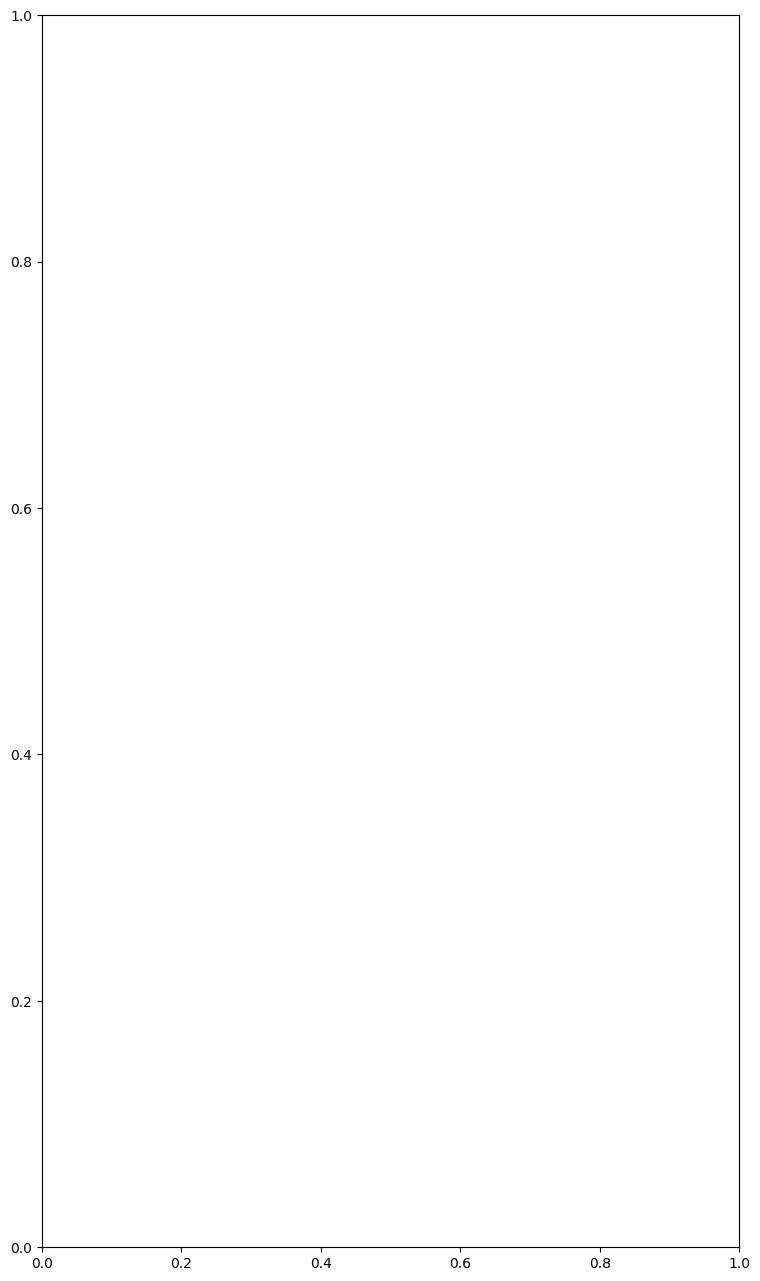

In [69]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

We can also plot all annotations across all sample data for that sample. Note how for radar we also plot the velocity vectors of moving objects. Some velocity vectors are outliers, which can be filtered using the settings in RadarPointCloud.from_file()

In [68]:
my_sample = nusc.sample[20]

# The rendering command below is commented out because it may crash in notebooks
# nusc.render_sample(my_sample['token'])

Or if we only want to render a particular sensor, we can specify that.

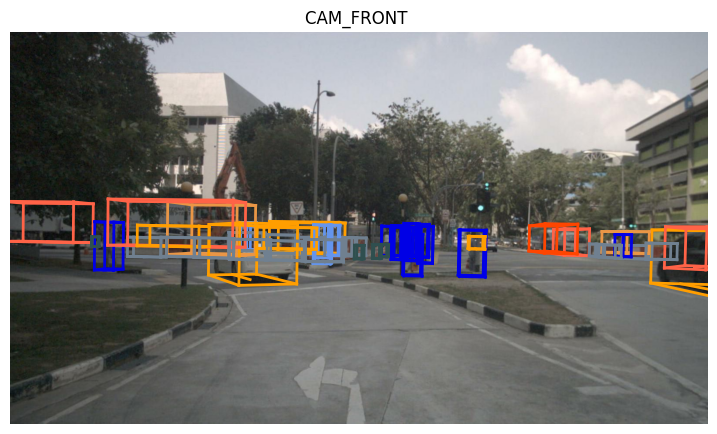

In [67]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

Additionally we can aggregate the point clouds from multiple sweeps to get a denser point cloud.

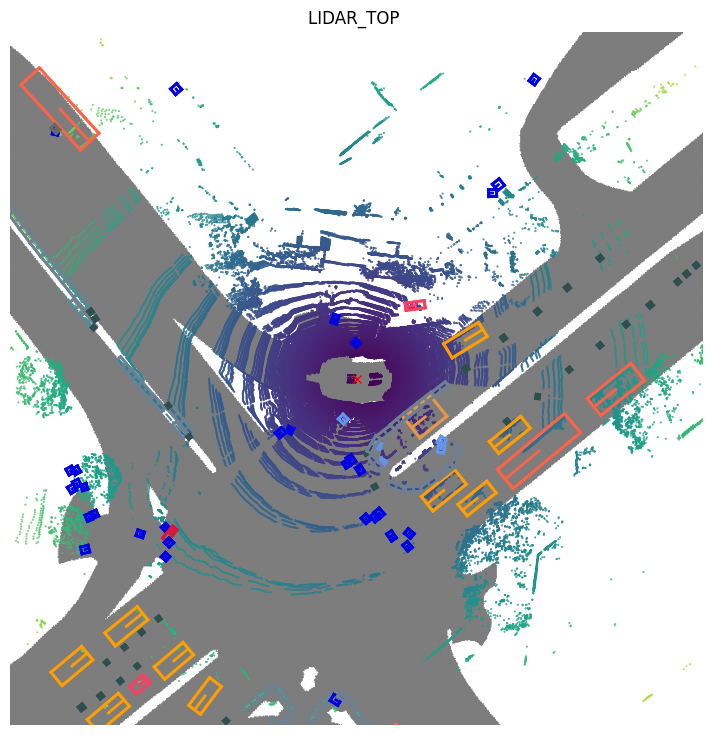

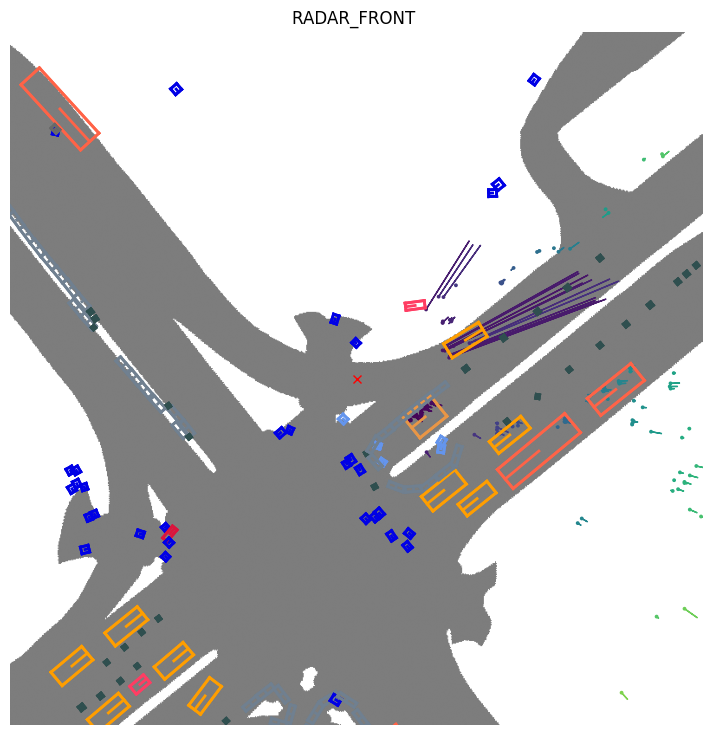

In [70]:
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=True)
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)

In the radar plot above we only see very confident radar returns from two vehicles. This is due to the filter settings defined in the file `nuscenes/utils/data_classes.py`. If instead we want to disable all filters and render all returns, we can use the `disable_filters()` function. This returns a denser point cloud, but with many returns from background objects. To return to the default settings, simply call `default_filters()`.

In [4]:
from nuscenes.utils.data_classes import RadarPointCloud
RadarPointCloud.disable_filters()
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)
RadarPointCloud.default_filters()

NameError: name 'my_sample' is not defined

We can even render a specific annotation.

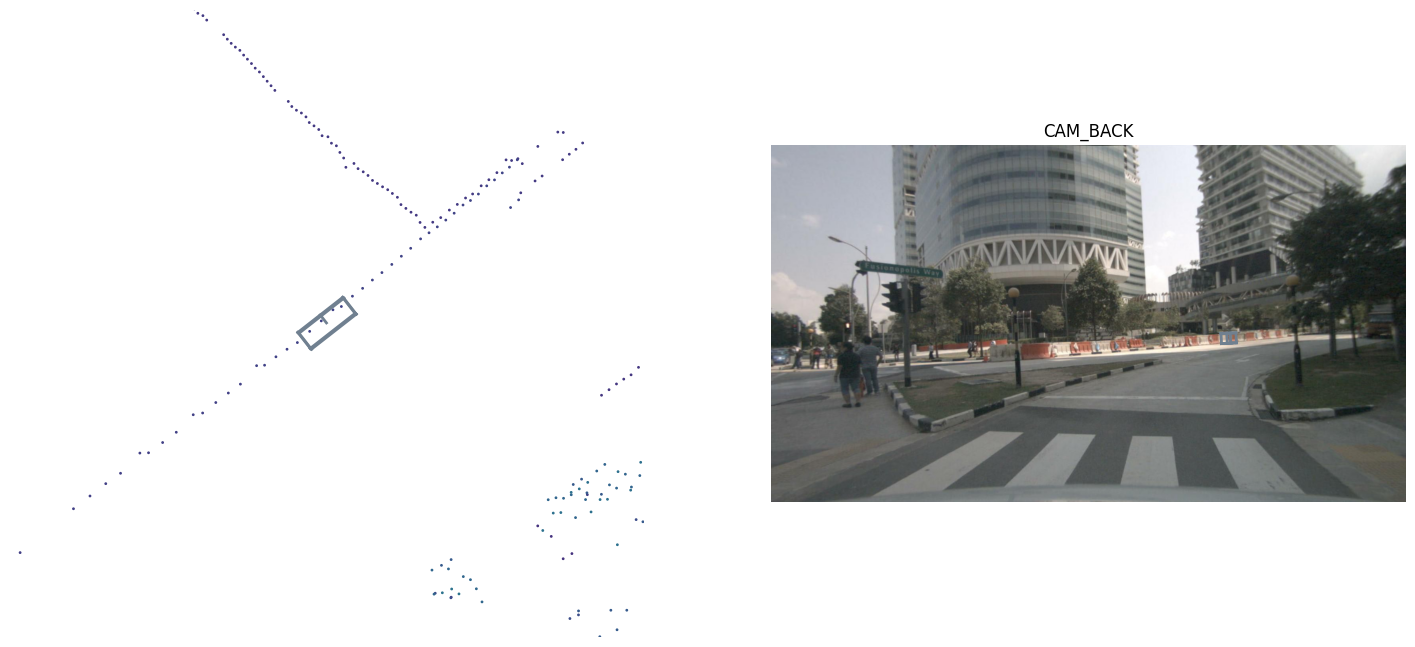

In [72]:
nusc.render_annotation(my_sample['anns'][22])

Finally, we can render a full scene as a video. There are two options here:
1. nusc.render_scene_channel() renders the video for a particular channel. (HIT ESC to exit)
2. nusc.render_scene() renders the video for all camera channels.

NOTE: These methods use OpenCV for rendering, which doesn't always play nice with IPython Notebooks. If you experience any issues please run these lines from the command line.

Let's grab scene 0061, it is nice and dense.

In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)
my_scene_token = nusc.field2token('scene', 'name', 'scene-0061')[0]
nusc.render_scene(my_scene_token)

Loading NuScenes tables for version v1.0-mini...


In [75]:
# The rendering command below is commented out because it may crash in notebooks
# nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

There is also a method nusc.render_scene() which renders the video for all camera channels.
This requires a high-res monitor, and is also best run outside this notebook.

In [ ]:
nusc.render_scene(my_scene_token)

Finally, let us visualize all scenes on the map for a particular location.

In [1]:
nusc.render_egoposes_on_map(log_location='singapore-onenorth')

NameError: name 'nusc' is not defined